# XGB and RF Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/clean_train.csv").drop(columns="Unnamed: 0")

In [3]:
join_df = pd.read_csv("../data/purchase_counts.csv").drop(columns="Unnamed: 0")

In [4]:
max_features = pd.read_csv("../data/max_features.csv")

In [5]:
max_features = max_features.drop(columns=["week1_purchaser", "week2_purchaser", "US", "GB", "activity_variance", 
                                         "Week_10_Count"])

In [6]:
join_df.index = join_df.user_id_hash
join_df.drop(columns="user_id_hash", inplace=True)

In [7]:
df = df.join(join_df, on="user_id_hash", how="left")

In [8]:
df.purchase_count = df.purchase_count.fillna(value=0)

In [9]:
df = df.join(max_features.set_index("user_id_hash"), on="user_id_hash", how="left")

In [10]:
df = df.drop(columns=["previous_sessions_duration", "avg_count_per_session", "avg_purchase_amt_per_session",
                      "session_index", "purchase_amt_total" , "GB", "Week_4_Count", "Week_3_Count", "Week_2_Count",
                      "PH", "Week_6_Count", "total_countries", "Week_8_Count", "Week_1_Count", 
                      "Week_10_Count", "Week_5_Count", "Week_7_Count", "CA", "Week_9_Count",
                      "purchase_amt_total", "duration_session_ratio"])

In [11]:
df.loc[:, "avg_session_length"] = df.loc[:, "avg_session_length"]/60/60

## Prep Data

In [13]:
X = df.drop(columns=["week1_purchaser", "week2_purchaser", "user_id_hash"])
y1 = df.week1_purchaser
y2 = df.week2_purchaser

Using 50% of data to train since we are predicting about 312,000 users for submission

In [14]:
int(len(df) * 0.5)

309434

In [15]:
split = int(len(df) * 0.5)

In [16]:
X_train, X_test = X[:split], X[split:]
y1_train, y1_test = y1[:split], y2[split:]
y2_train, y2_test = y2[:split], y2[split:]

## Set up models

Use 80-85% of columns per tree

In [17]:
len(X_train.columns)

22

In [18]:
len(X_train.columns)*.75

16.5

In [19]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_leaf=13, max_features=0.8)
xgb = XGBClassifier(max_depth=3, learning_rate=0.25, n_estimators=200, n_jobs=-1, colsample_bytree=0.85)

## Train

In [20]:
xgb_week1 = xgb.fit(X_train, y1_train)
xgb_week2 = xgb.fit(X_train, y2_train)
rf_week1 = rf.fit(X_train, y1_train)
rf_week2 = rf.fit(X_train, y2_train)

## Predict

In [21]:
xgb_pred1 = xgb_week1.predict_proba(X_test)[:,1]
xgb_pred2 = xgb_week2.predict_proba(X_test)[:,1]
xgb_pred1_train = xgb_week1.predict_proba(X_train)[:,1]
xgb_pred2_train = xgb_week2.predict_proba(X_train)[:,1]
rf_pred1 = rf_week1.predict_proba(X_test)[:,1]
rf_pred2 = rf_week2.predict_proba(X_test)[:,1]
rf_pred1_train = rf_week1.predict_proba(X_train)[:,1]
rf_pred2_train = rf_week2.predict_proba(X_train)[:,1]

In [22]:
print(f"XGB Week1 Train: {roc_auc_score(y1_train, xgb_pred1_train)}")
print(f"XGB Week1 Val: {roc_auc_score(y1_test, xgb_pred1)}")
print(f"XGB Week2 Train: {roc_auc_score(y2_train, xgb_pred2_train)}")
print(f"XGB Week2 Val: {roc_auc_score(y2_test, xgb_pred2)}")

XGB Week1 Train: 0.9989401207392606
XGB Week1 Val: 0.9941076240829875
XGB Week2 Train: 0.9983374509053123
XGB Week2 Val: 0.9941076240829875


In [23]:
print(f"RF Week1 Train: {roc_auc_score(y1_train, rf_pred1_train)}")
print(f"RF Week1 Val: {roc_auc_score(y1_test, rf_pred1)}")
print(f"RF Week2 Train: {roc_auc_score(y2_train, rf_pred2_train)}")
print(f"RF Week2 Val: {roc_auc_score(y2_test, rf_pred2)}")

RF Week1 Train: 0.9991680903013287
RF Week1 Val: 0.9927091793272849
RF Week2 Train: 0.9989178554535013
RF Week2 Val: 0.992709179327285


## Train Full Data

In [24]:
unique_users = pd.DataFrame(df.user_id_hash.unique(), columns=["user_id_hash"])

In [25]:
submission = pd.read_csv("../data/sample_submission_2.csv")

In [27]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, min_samples_leaf=13, max_features=0.8)
rf_week1 = rf.fit(X, y1)
rf_week2 = rf.fit(X, y2)
rf_week1_pred = rf_week1.predict_proba(X)[:,1]
rf_week2_pred = rf_week2.predict_proba(X)[:,1]
print(f"Week1 Train: {roc_auc_score(y1, rf_week1_pred)}")
print(f"Week2 Train: {roc_auc_score(y2, rf_week2_pred)}")

Week1 Train: 0.998763448206829
Week2 Train: 0.9988072023539776


In [28]:
rf_features = sorted(list(zip(X.columns, rf_week1.feature_importances_)), key=lambda x: x[1], reverse=True)

In [29]:
for f in rf_features[:15]:
    print(f"{f[0]}  |  {f[1]:.4f}")

event_value  |  0.2475
num_Week9_sessions  |  0.2415
event_value_per_session  |  0.1653
purchase_count  |  0.1296
total_session_length  |  0.0787
avg_session_length  |  0.0431
num_total_sessions  |  0.0202
num_Week8_sessions  |  0.0191
days_since_creation  |  0.0120
avg_attributes_per_session  |  0.0103
activity_variance  |  0.0098
num_Week7_sessions  |  0.0067
num_Week6_sessions  |  0.0035
num_Week5_sessions  |  0.0026
Android OS  |  0.0021


In [30]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.25, n_estimators=200, n_jobs=-1, colsample_bytree=0.85)
xgb_week1 = xgb.fit(X, y1.values)
xgb_week2 = xgb.fit(X, y2.values)
xgb_week1_pred = xgb_week1.predict_proba(X)[:,1]
xgb_week2_pred = xgb_week2.predict_proba(X)[:,1]
print(f"Week1 Train: {roc_auc_score(y1, xgb_week1_pred)}")
print(f"Week2 Train: {roc_auc_score(y2, xgb_week2_pred)}")

Week1 Train: 0.9975945226809051
Week2 Train: 0.9967698178495873


In [31]:
xgb_features = sorted(list(zip(X.columns, xgb_week1.feature_importances_)), key=lambda x: x[1], reverse=True)

In [32]:
for f in xgb_features:
    print(f"{f[0]}  |  {f[1]:.4f}")

event_value  |  0.3605
total_session_length  |  0.1142
num_Week9_sessions  |  0.0932
event_value_per_session  |  0.0901
avg_session_length  |  0.0886
purchase_count  |  0.0824
activity_variance  |  0.0256
num_Week8_sessions  |  0.0233
avg_attributes_per_session  |  0.0194
days_since_creation  |  0.0163
num_Week7_sessions  |  0.0140
num_total_sessions  |  0.0124
Android OS  |  0.0101
num_Week4_sessions  |  0.0093
num_Week6_sessions  |  0.0093
num_Week5_sessions  |  0.0078
US  |  0.0062
num_Week3_sessions  |  0.0054
iOS  |  0.0047
IN  |  0.0039
num_Week2_sessions  |  0.0023
num_Week10_sessions  |  0.0008


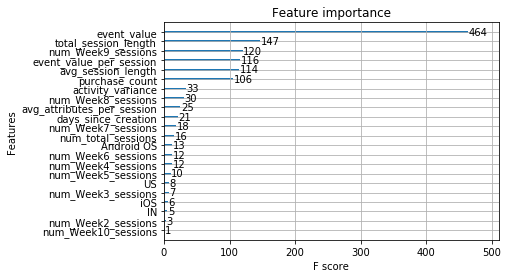

In [33]:
plot_importance(xgb_week1)
plt.savefig("../data/xgb_features.png")
plt.savefig("../data/feature_importance.jpeg", bbox_inches="tight")
plt.show()

## Join XGB Predictions with Submission

In [34]:
predictions = pd.DataFrame(np.vstack((unique_users.user_id_hash, xgb_week1_pred, xgb_week2_pred))).T

In [35]:
predictions.columns = ["user_id_hash", "week1", "week2"]
predictions.index = predictions["user_id_hash"]
predictions = predictions.drop(columns="user_id_hash")

In [36]:
submission = submission.join(predictions, on="user_id_hash", how="left")
submission = submission.drop(columns=["user_purchase_binary_7_days", "user_purchase_binary_14_days"])
submission.columns = ["user_id_hash", "user_purchase_binary_7_days", "user_purchase_binary_14_days"]

In [37]:
submission.user_purchase_binary_7_days = submission.user_purchase_binary_7_days.fillna(value=np.mean(xgb_week1_pred))
submission.user_purchase_binary_14_days = submission.user_purchase_binary_14_days.fillna(value=np.mean(xgb_week2_pred))

### Write to CSV for submission

In [38]:
submission.to_csv("../data/xgb_predictions.csv", index=False)